https://www.kaggle.com/datasets/ulrikthygepedersen/electricity-demands

things to improve
- create standard size variable to easily adjust
- the entire project

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from river import metrics
from river.drift import ADWIN

In [316]:
data = pd.read_csv("/Users/williamzwetolitz/Desktop/ds440/DS440/electricity.csv")
data['class'] = data['class'].astype(pd.StringDtype())
data['class'] = data['class'].str.replace("b'UP'", '1')
data['class'] = data['class'].str.replace("b'DOWN'", '0')
data['class'] = data['class'].astype(int)
data.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [317]:
data.shape

(45312, 9)

In [318]:
original_train = data.head(5000) # using 5000 rows for orginal training of model
test_data = data.tail(45312) # rest of the data will be the "new" incoming data we test on
original_train.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [319]:
X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

logreg = LogisticRegression()
adwin = ADWIN()

f1_scores = []
drift_spots = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if X_train.shape[0] > 0:
            logreg.fit(X_train, y_train)

    else:
        y_pred = logreg.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            drift_spots.append(i)
            logreg = LogisticRegression()
            logreg.fit(X[i-5000:i], y[i-5000:i])
            adwin = ADWIN()

In [320]:
#print(f1_scores)
print(len(drift_spots))

53


In [321]:
drift_diff = [x - drift_spots[i - 1] for i, x in enumerate(drift_spots)][1:]
print(drift_spots)

[5191, 5447, 6023, 6695, 7015, 7239, 7495, 7847, 9255, 10279, 10791, 12071, 12647, 15719, 16199, 18695, 19335, 19783, 19975, 20295, 20807, 20967, 21191, 21799, 22023, 22311, 26375, 27015, 27911, 28327, 28871, 28999, 29447, 29863, 30119, 30439, 30791, 30983, 31463, 31975, 32359, 32903, 33511, 33831, 34183, 36167, 37575, 37959, 38375, 39079, 39367, 39783, 40167]


In [322]:
cleaned_spots = [(x - 5000)/50 for x in drift_spots]

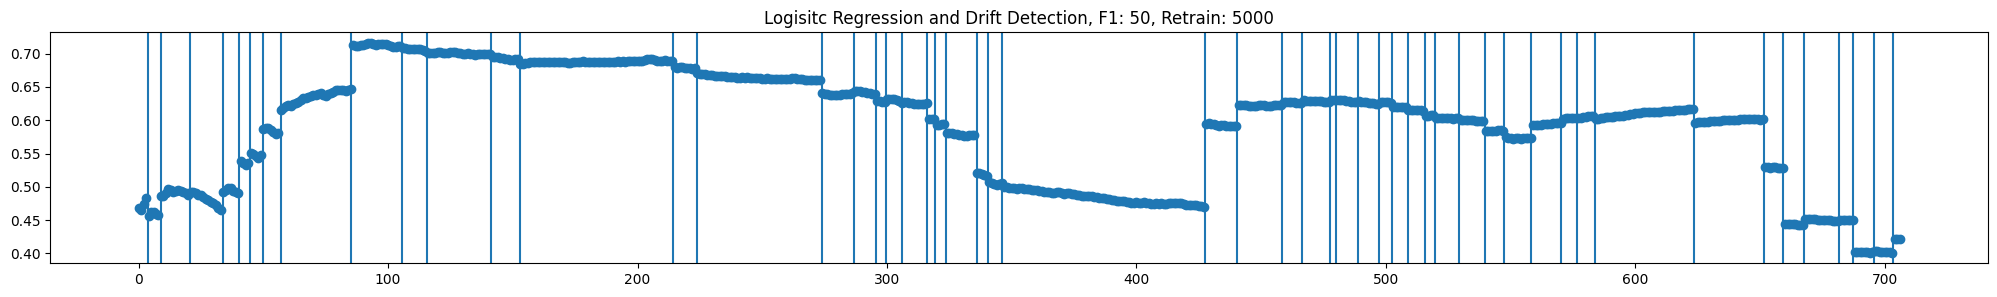

In [323]:
#fig = plt.figure(figsize=(9,3), tight_layout=True)
f1_array = np.array(f1_scores)
xs = [x for x in range(len(f1_scores))]
plt.rcParams['figure.figsize'] = [25,3]
for i in cleaned_spots:
    plt.axvline(x=i)
plt.scatter(xs, f1_array)
plt.title("Logisitc Regression and Drift Detection, F1: 50, Retrain: 5000")
plt.show()


In [324]:
print("average f1 score: " + str(sum(f1_scores)/len(f1_scores)))

average f1 score: 0.5943040020036943


Below is the model without drift detection

In [ ]:
X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

logreg = LogisticRegression()
f1_scores_2 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if X_train.shape[0] > 0:
            logreg.fit(X_train, y_train)

    else:
        y_pred = logreg.predict(x.reshape(1, -1))[0]
        if i % 50 == 0:
            y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores_2.append(f1_score(y_test[:i+1], y_pred_history))

print(f1_scores_2)

In [330]:
print(sum(f1_scores_2)/len(f1_scores_2))

0.39697870922904943


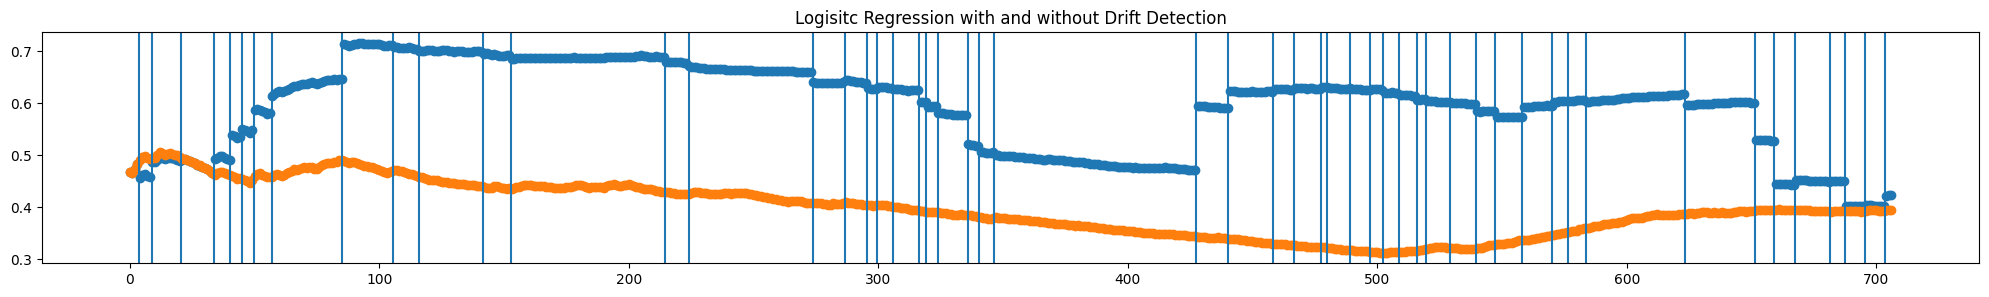

In [326]:
f1_2_array = np.array(f1_scores_2)
xs = [x for x in range(len(f1_scores))]
plt.rcParams['figure.figsize'] = [25,3]
for i in cleaned_spots:
    plt.axvline(x=i)
plt.scatter(xs, f1_array)
plt.scatter(xs, f1_2_array)
plt.title("Logisitc Regression with and without Drift Detection")
plt.show()

Below is a test on generated data

In [327]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from river.drift import ADWIN

# Generate a random dataset
X, y = make_classification(n_samples=45000, n_features=10, n_informative=5, random_state=42)

X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

logreg = LogisticRegression()
adwin = ADWIN()
f1_scores_3 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):

    if i < 5000:
        logreg.fit(X_train, y_train)
        
    y_pred = logreg.predict(x.reshape(1, -1))[0]
    adwin.update(int(y_pred == y_true))
    
    if i % 50 == 0:
        y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
        f1_scores.append(f1_score(y_test[:i+1], y_pred_history))
    
    if adwin.drift_detected:
        logreg = LogisticRegression()
        adwin = ADWIN()

print(f1_scores_3)

[]


In [328]:
print(sum(f1_scores_3)/len(f1_scores_3))

ZeroDivisionError: division by zero

Varying f1 score subset size and retraining size  - Improves f1 scores slightly, increases run time significantly

retraining size vs avg f1:

2500 - 0.5581,
5000 - 0.5943,
7500 - 0.6358

f1 scores do not improve much with an increased training size, the smaller training size might be worth it despite the small loss in performance. 2500 has a lot more variability in the f1 scores, including larger drops between before/after drift detection

In [ ]:
X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:2500], X[2500:], y[:2500], y[2500:]

logreg = LogisticRegression()
adwin = ADWIN()

f1_scores_4 = []
drift_spots_2 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 2500:
        if X_train.shape[0] > 0:
            logreg.fit(X_train, y_train)

    else:
        y_pred = logreg.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores_4.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            drift_spots_2.append(i)
            logreg = LogisticRegression()
            logreg.fit(X[i-2500:i], y[i-2500:i])
            adwin = ADWIN()

print(f1_scores_4)

In [ ]:
cleaned_spots_2 = [(x - 2500)/50 for x in drift_spots_2]

In [ ]:
print(sum(f1_scores_4)/len(f1_scores_4))

0.5581150678432557


In [ ]:
print(len(drift_spots_2))

55


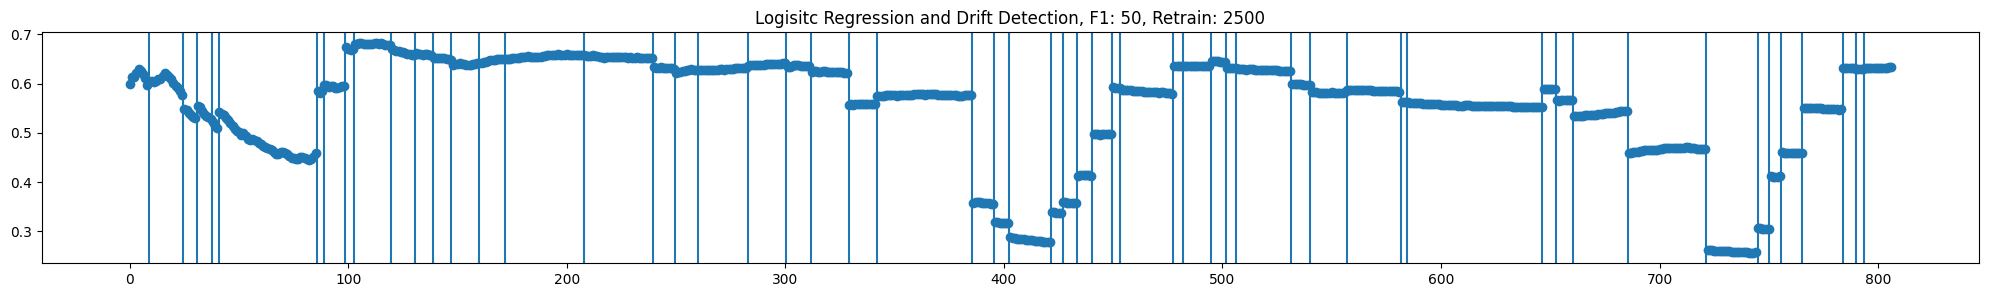

In [ ]:
f1_array_4 = np.array(f1_scores_4)
xs = [x for x in range(len(f1_scores_4))]
plt.rcParams['figure.figsize'] = [25,3]
for i in cleaned_spots_2:
    plt.axvline(x=i)
plt.scatter(xs, f1_array_4)
plt.title("Logisitc Regression and Drift Detection, F1: 50, Retrain: 2500")
plt.show()

Retraining Model on most recent subset of data since last drift spot, if the subset is too small use the pretrain size
(use max of recent subset or pretrain size)

First need to find a way for the model to detect drift less often, so that it uses the subsets more often and uses outdated data less often

In [ ]:
X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

logreg = LogisticRegression()
adwin = ADWIN()

f1_scores_5 = []
drift_spots_3 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if X_train.shape[0] > 0:
            logreg.fit(X_train, y_train)

    else:
        y_pred = logreg.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores_5.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            logreg = LogisticRegression()
            #print(i - drift_spots_3[-1]) 
            if drift_spots_3 and (i - drift_spots_3[-1]) > 750:  # this is where we can vary the set max for retraining, I don't think this is working
              logreg.fit(X[drift_spots_3[-1]:i], y[drift_spots_3[-1]:i])
              print(i)
            else:
              logreg.fit(X[i-5000:i], y[i-5000:i])
            adwin = ADWIN()
            drift_spots_3.append(i)

#print(f1_scores_5)

#print(drift_spots)

9255
10087
12135
15719
18695
19463
26375
27911
36167
38311


In [ ]:
print(sum(f1_scores_5)/len(f1_scores_5))

0.581745981575111


using the code block above, adjust to compare the size of the last 2 or 3 subsets compared to the set size. Hopefully improved performance

In [333]:
X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

logreg = LogisticRegression()
adwin = ADWIN()

f1_scores_6 = []
drift_spots_4 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if X_train.shape[0] > 0:
            logreg.fit(X_train, y_train)

    else:
        y_pred = logreg.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores_6.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            logreg = LogisticRegression()
            get_len = len(drift_spots_4)
            if (get_len > 2) and (i - drift_spots_4[-2]) > 100:  # this is where we can vary the set max for retraining, I don't think this is working
              logreg.fit(X[drift_spots_4[-2]:i], y[drift_spots_4[-2]:i])
              print(i)
            else:
              logreg.fit(X[i-5000:i], y[i-5000:i])
            adwin = ADWIN()
            drift_spots_4.append(i)


6695
7015
7463
7975
8583
8775
10279
11975
12231
12807
16071
16295
19847
20071
20391
20615
21063
22023
22407
22631
22887
23335
23815
24231
26503
27015
27559
27687
28263
28743
29063
29383
29767
30087
30279
30855
32711
34023
34375
35591
36583
37159
37415
38311
38759
39079
39399
40007


In [ ]:
print(sum(f1_scores_6)/len(f1_scores_6))

0.5541168485969291


In [332]:
X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

logreg = LogisticRegression()
adwin = ADWIN()

f1_scores_7 = []
drift_spots_5 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if X_train.shape[0] > 0:
            logreg.fit(X_train, y_train)

    else:
        y_pred = logreg.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = logreg.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores_7.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            logreg = LogisticRegression()
            get_len = len(drift_spots_5)
            if get_len > 2:
                logreg.fit(X[drift_spots_3[-1]:i], y[drift_spots_3[-1]:i])
                print(i)
            else:
                logreg.fit(X[i-5000:i], y[i-5000:i])
            adwin = ADWIN()
            drift_spots_5.append(i)


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by LogisticRegression.